In [198]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [2]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки. В отличие от проекта, который вас ждет, здесь мы будем работать не с сырыми данными (аудиодорожками), а уже в осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [31]:
data.shape

(17996, 17)

In [33]:
data.dtypes #Смотрим на типы переменных

Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

In [213]:
data.describe() # Смотрим на распределения переменных

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [32]:
nas = data.isna().sum(axis=0)  # посчитаем количество пропущенных значений в каждом столбце

In [28]:
nas # Как видно, столбцы Popularity, key, instrumentalness содержат большое количество пропущенных значений

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

In [29]:
data['Class'].value_counts() # Посчитаем количество объектов в каждом классе

10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: Class, dtype: int64

In [214]:
data.corr() # Посмотрим, есть ли коррелирующие переменные

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
Popularity,1.000000,0.167213,0.051538,0.005901,0.124915,0.016584,0.031664,-0.125410,-0.167661,-0.072298,0.054824,-0.006050,-0.031118,0.067062,0.161072
danceability,0.167213,1.000000,-0.093838,0.006702,0.059723,-0.067135,0.199042,0.009055,-0.200752,-0.109485,0.444548,-0.183527,-0.121624,0.137455,-0.097681
energy,0.051538,-0.093838,1.000000,0.015934,0.767869,-0.035880,0.125427,-0.745963,-0.180276,0.195634,0.222998,0.210224,0.245768,0.145281,0.217328
key,0.005901,0.006702,0.015934,1.000000,0.002660,-0.112452,0.001822,-0.009112,0.001411,0.015125,0.031744,0.013965,0.014547,0.006965,-0.007829
loudness,0.124915,0.059723,0.767869,0.002660,1.000000,-0.033650,0.096027,-0.612824,-0.343672,0.112022,0.181086,0.164272,0.172010,0.127775,0.177872
mode,0.016584,-0.067135,-0.035880,-0.112452,-0.033650,1.000000,-0.074609,0.024035,-0.026771,-0.001563,-0.002986,0.021211,-0.069307,-0.019989,-0.044740
speechiness,0.031664,0.199042,0.125427,0.001822,0.096027,-0.074609,1.000000,-0.086648,-0.067632,0.070406,0.053885,0.048948,0.005044,0.056237,-0.059349
acousticness,-0.125410,0.009055,-0.745963,-0.009112,-0.612824,0.024035,-0.086648,1.000000,0.174139,-0.111393,-0.122547,-0.168318,-0.322583,-0.133936,-0.237138
instrumentalness,-0.167661,-0.200752,-0.180276,0.001411,-0.343672,-0.026771,-0.067632,0.174139,1.000000,-0.047189,-0.228144,-0.038586,-0.004551,-0.061745,-0.025343
liveness,-0.072298,-0.109485,0.195634,0.015125,0.112022,-0.001563,0.070406,-0.111393,-0.047189,1.000000,0.021076,0.033515,0.053885,0.021546,0.045309


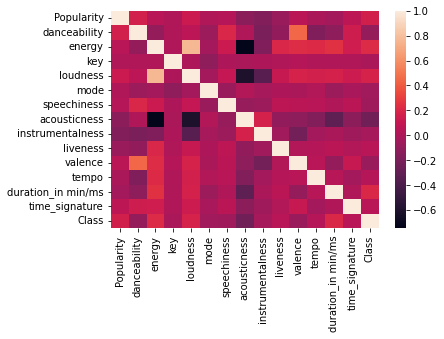

In [36]:
hm = sns.heatmap(data.corr(),
                 cbar=True,
                 annot=False)

In [38]:
# Параметры acousticness и loudness хорошо коррелируют с параметром energy, 
# возможно при создании модели имеет смысл использовать energy вместо них обоих. 

In [211]:
# Посмотрим на распределения

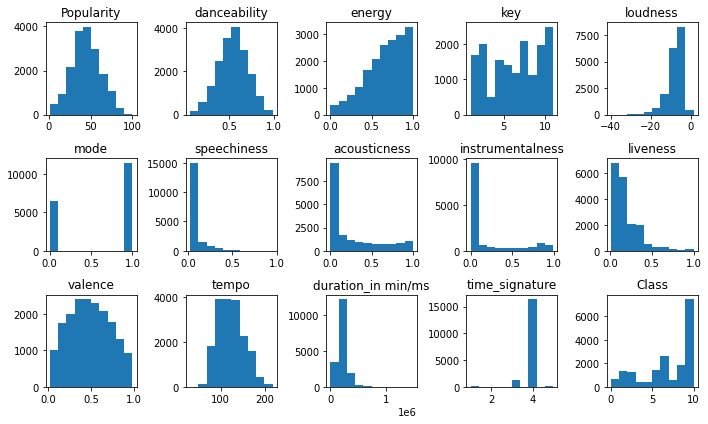

In [210]:
plot_data = data.drop(data.columns[[0,1]], axis=1)
plt.figure(figsize=(10, 6))
for i in range(plot_data.shape[1]):
    plt.subplot(3, 5, i+1)
    plt.tight_layout()
    plt.hist(x=plot_data.iloc[:,[i]])
    plt.title(plot_data.columns[i])
plt.show()

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [147]:
# Выбросим переменные содержащие имя артиста, название трека и переменные имеющие пропущенные значения.

In [142]:
data_prepro = data.drop(['Artist Name', 'Track Name','instrumentalness', 'key'], axis=1)

In [146]:
data_prepro = data_prepro.fillna({'Popularity': data_prepro['Popularity'].mean()}) 
# поскольку в колонке Popularity не так много пропущенных значений, возможно имеет смысл ее оставить,
# заменив пропущенные значения на среднее по признаку.

In [151]:
X = data_prepro.drop('Class', axis=1)
y = data_prepro['Class']

In [153]:
# выполним стандартизацию, поскольку значения признаков существенно отличаются между собой

X = StandardScaler().fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=SEED)

In [35]:
tree = DecisionTreeClassifier()

In [212]:
#подберем лучшие значения.

In [157]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_leaf_nodes' : range(50,350,50),
              'min_samples_split': range(2,10,2),
             'min_samples_leaf' : range(2,10,2),
             }

In [158]:
search = GridSearchCV(tree, parameters)

In [159]:
search.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': range(50, 350, 50),
                         'min_samples_leaf': range(2, 10, 2),
                         'min_samples_split': range(2, 10, 2)})

In [160]:
search.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=150, min_samples_leaf=4)

In [161]:
search.best_score_

0.47061687121299833

In [215]:
#попробуем с максимальной глубиной.

In [164]:
parameters2 = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,21,5),
              'min_samples_split': range(2,10,2),
             'min_samples_leaf' : range(2,10,2),
             }

In [165]:
search2 = GridSearchCV(tree, parameters2)
search2.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 21, 5),
                         'min_samples_leaf': range(2, 10, 2),
                         'min_samples_split': range(2, 10, 2)})

In [166]:
search2.best_estimator_

DecisionTreeClassifier(max_depth=11, min_samples_leaf=8)

In [167]:
search2.best_score_

0.4477630880707036

In [208]:
# Возьмем наилучшее дерево из двух

In [170]:
best_tree = DecisionTreeClassifier(max_leaf_nodes=150, min_samples_leaf=4)

In [171]:
best_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=150, min_samples_leaf=4)

In [172]:
y_pred = best_tree.predict(X_test)

In [174]:
#Оценим качество классификации.

In [209]:
# Поскольку в данных наблюдается дисбаланс классов, метрику accuracy использовать нельзя. Будем использовать f1.

In [173]:
print(f1_score(y_test,y_pred, average='macro'))

0.4915797412604809


### Задание 3. Другие модели (5 баллов за модель)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

# Knn

In [206]:
# Подберем лучшие параметры

In [181]:
knn = KNeighborsClassifier()
parameters_knn = {'n_neighbors' : range(5, 100, 5),
                 'metric' : ['minkowski','euclidean', 'canberra' ]}
best_knn = GridSearchCV(knn, parameters_knn)

In [182]:
best_knn.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'canberra'],
                         'n_neighbors': range(5, 100, 5)})

In [184]:
best_knn.best_estimator_

KNeighborsClassifier(n_neighbors=55)

In [185]:
best_knn.best_score_

0.4846489907761183

In [196]:
# сузим поиск

In [188]:
parameters_knn2 = {'n_neighbors' : range(45, 65, 1)}
best_knn2 = GridSearchCV(knn, parameters_knn2)

In [189]:
best_knn2.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(45, 65)})

In [190]:
best_knn2.best_estimator_

KNeighborsClassifier(n_neighbors=55)

In [216]:
# Возьмем лучшие параметры

In [193]:
knn_best = KNeighborsClassifier(n_neighbors=55)
knn_best.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=55)

In [194]:
pred_knn = knn_best.predict(X_test)

In [195]:
print(f1_score(y_test,pred_knn, average='macro'))

0.5041721455244501


# SVC

In [207]:
# Подберем лучшие параметры

In [199]:
parameters_svc = {'kernel':('linear', 'rbf'), 
              'C':range(1,10)}
svc = svm.SVC(class_weight='balanced')
best_SVC = GridSearchCV(svc, parameters_svc) 

In [200]:
best_SVC.fit(X_train,y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': range(1, 10), 'kernel': ('linear', 'rbf')})

In [201]:
best_SVC.best_estimator_

SVC(C=2, class_weight='balanced')

In [203]:
SVC_best = svm.SVC(C=2, class_weight='balanced')
SVC_best.fit(X_train,y_train)

SVC(C=2, class_weight='balanced')

In [204]:
pred_SVC = SVC_best.predict(X_test)

In [205]:
print(f1_score(y_test,pred_SVC, average='macro'))

0.5276772395171743






Стало лучше, но не сильно)

### Задание 4. (3 балла)

Раз уж вы работаете в командах, то у вас есть шанс обсудить любимые фильмы. Напишите сюда 3 фильма, которые хотели бы посмотреть вместе:

1.

2.

3.

Я делал задние один, так что вот просто 3 фильма)(

О настоящем: 

1. "Война" Алексея Балабанова

О ближайшем будущем(:

2. "Груз 200" Алексея Балабанова

Об одаленном будущем):

3. "Generation П" 
